In [13]:
import json
import os
import csv
import glob
import pandas as pd
from collections import Counter
from estnltk import Text
from estnltk.converters import json_to_text
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
def speech_jsonist_per_episode(dir, gender_tag):

    episodid = []
    
    for fail in os.listdir(dir):
        f_nimi = os.path.join(dir, fail)
        if not fail.endswith('.json'):
            continue
        with open(f_nimi, 'r') as f:
       
            andmed = json.load(f)
            
        total_seconds = 0.0 
        turns = []
        for section in andmed['sections']:
            if 'turns' in section.keys():
                start, end = float(section['start']), float(section['end'])
                total_seconds += (end - start)
                for t in section['turns']:
                    turns.append(t['transcript'])
        episodid.append({
            'episode_id': fail.replace('.json',''),
            'gender': gender_tag,
            'minutid': total_seconds / 60.0,
            'transcript': ' '.join(turns)
        })
    return episodid

In [3]:
men_eps = speech_jsonist_per_episode('mehed', 'M')
women_eps = speech_jsonist_per_episode('naised', 'F')
all_eps = men_eps + women_eps

In [4]:
def count_pos_features(transcript, minutid):
    txt = Text(transcript).tag_layer('morph_analysis')
    counters = { PoS: Counter() for PoS in
                 ['asesõnad','omadussõnad','nimisõnad','adverbid','verbid','partiklid','kaassõnad'] }
    map_tag = {'P':'asesõnad','A':'omadussõnad','S':'nimisõnad',
               'D':'adverbid','V':'verbid','I':'partiklid','K':'kaassõnad'}
    for token in txt.morph_analysis:
        tag = token.partofspeech[0]
        if tag in map_tag:
            lemma = token.lemma[0].lower()
            counters[map_tag[tag]][lemma] += 1
  
    rows = []
    for pos, ctr in counters.items():
        raw = sum(ctr.values())
        norm = (raw / minutid) * 60 if minutid>0 else 0.0
        rows.append({'sõnaliigid': pos,
                     'raw_count': raw,
                     'freq_per_60_min': norm})
    return rows

In [5]:
records = []
for ep in all_eps:
    rows = count_pos_features(ep['transcript'], ep['minutid'])
    for r in rows:
        records.append({
            'episode_id': ep['episode_id'],
            'gender': ep['gender'],
            'sõnaliigid': r['sõnaliigid'],
            'minutid': ep['minutid'],
            'raw_count': r['raw_count'],
            'freq_per_60_min': r['freq_per_60_min']
        })

df = pd.DataFrame.from_records(records)

In [6]:
df.to_csv('pos_by_episode.csv', index=False)

# ANOVA

model = ols('freq_per_60_min ~ C(sõnaliigid)*C(gender)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                               sum_sq     df           F        PR(>F)
C(sõnaliigid)            3.646689e+08    6.0  999.242838  0.000000e+00
C(gender)                2.553416e+06    1.0   41.980264  1.697950e-10
C(sõnaliigid):C(gender)  1.653702e+06    6.0    4.531369  1.601865e-04
Residual                 4.428002e+07  728.0         NaN           NaN


In [7]:
# „sugu + PoS“ moodustamine
df['group'] = df['gender'] + '_' + df['sõnaliigid']

# Tukey
tukey = pairwise_tukeyhsd(
    endog=df['freq_per_60_min'],
    groups=df['group'],
    alpha=0.05
)

# DataFrame
res = pd.DataFrame(tukey._results_table.data[1:], 
                   columns=tukey._results_table.data[0])

# group1/group2
res[['g1','pos1']] = res['group1'].str.split('_', expand=True)
res[['g2','pos2']] = res['group2'].str.split('_', expand=True)

# F_vs_M PoS'i sees
res_simple = res[(res['pos1']==res['pos2']) & (res['g1'] != res['g2'])]

print(res_simple[['pos1','group1','group2','meandiff','p-adj','lower','upper','reject']])

           pos1         group1         group2  meandiff   p-adj     lower  \
6      adverbid     F_adverbid     M_adverbid -208.5603  0.0013 -370.2396   
19     asesõnad     F_asesõnad     M_asesõnad -216.4106  0.0007 -378.0899   
31    kaassõnad    F_kaassõnad    M_kaassõnad  -13.1389  1.0000 -174.8181   
42    nimisõnad    F_nimisõnad    M_nimisõnad -101.2607  0.6960 -262.9400   
52  omadussõnad  F_omadussõnad  M_omadussõnad  -61.0627  0.9924 -222.7420   
61    partiklid    F_partiklid    M_partiklid   11.4435  1.0000 -150.2357   
69       verbid       F_verbid       M_verbid -234.6309  0.0001 -396.3102   

       upper  reject  
6   -46.8811    True  
19  -54.7314    True  
31  148.5403   False  
42   60.4185   False  
52  100.6165   False  
61  173.1227   False  
69  -72.9517    True  


In [8]:
from scipy.stats import ttest_ind

for pos in df['sõnaliigid'].unique():
    sub = df[df['sõnaliigid']==pos]
    f = sub[sub.gender=='F']['freq_per_60_min']
    m = sub[sub.gender=='M']['freq_per_60_min']
    stat, p = ttest_ind(f, m, equal_var=False)
    print(f"{pos}: t={stat:.2f}, p={p:.4f}")

asesõnad: t=2.64, p=0.0100
omadussõnad: t=5.29, p=0.0000
nimisõnad: t=2.34, p=0.0210
adverbid: t=3.39, p=0.0012
verbid: t=3.45, p=0.0009
partiklid: t=-2.19, p=0.0314
kaassõnad: t=1.95, p=0.0535


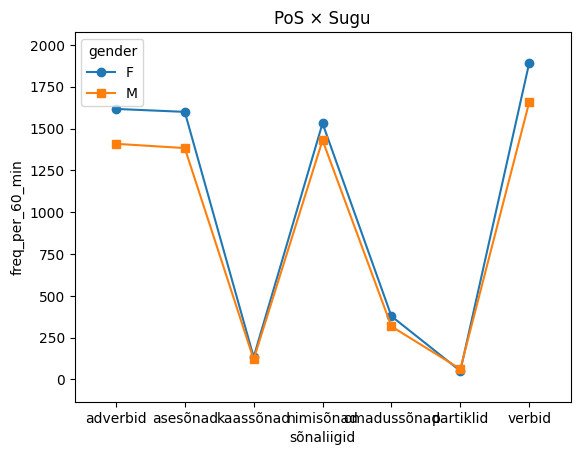

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(
    df['sõnaliigid'], df['gender'], df['freq_per_60_min'],
    colors=['tab:blue','tab:orange'], markers=['o','s'], ms=6
)
plt.ylabel('freq_per_60_min')
plt.xlabel('sõnaliigid')
plt.title('PoS × Sugu')
plt.show()

In [10]:
def loendamine(kone_episodist):
    tekst = Text(kone_episodist).tag_layer('morph_analysis')
    counters = {
        'omadussõnad': Counter(),
        'nimisõnad':   Counter(),
        'adverbid':    Counter(),
        'verbid':      Counter(),
        'asesõnad':    Counter(),
        'partiklid':   Counter(),
        'kaassõnad':   Counter(),
    }
    tag_map = {'A':'omadussõnad','S':'nimisõnad','D':'adverbid',
               'V':'verbid','P':'asesõnad','I':'partiklid','K':'kaassõnad'}

    for token in tekst.morph_analysis:
        tag = token.partofspeech[0]
        if tag in tag_map:
            key = tag_map[tag]
            # partiklide kohta võtan teksti
            form = token.text.lower() if tag=='I' else token.lemma[0].lower()
            counters[key][form] += 1

    return counters

# DataFrame kõikide pos ja episodide jaoks
records = []
for ep in all_eps:
    counts = loendamine(ep['transcript'])
    for pos, counter in counts.items():
        for form, cnt in counter.items():
            records.append({
                'episode_id':      ep['episode_id'],
                'gender':          ep['gender'],
                'minutid':         ep['minutid'],
                'sõnaliik':        pos,
                'feature':         form,
                'raw_count':       cnt,
                'freq_per_60_min': (cnt / ep['minutid']) * 60 if ep['minutid']>0 else 0.0
            })

df_all_pos = pd.DataFrame(records)

# CSV
df_all_pos.to_csv('all_pos_by_episode.csv', index=False)

In [11]:
os.makedirs('pos_csv', exist_ok=True)

# Ainulaadsete PoSide loend
pos_list = df_all_pos['sõnaliik'].unique()

# Iga sõnaliigi jaoks eraldi CSV
for pos in pos_list:
    df_pos = df_all_pos[df_all_pos['sõnaliik'] == pos].copy()
    filename = os.path.join('pos_csv', f'{pos}_by_episode.csv')
    df_pos.to_csv(filename, index=False)
    print(f"Saved {len(df_pos)} rows to {filename}")

Saved 11951 rows to pos_csv/omadussõnad_by_episode.csv
Saved 47400 rows to pos_csv/nimisõnad_by_episode.csv
Saved 20020 rows to pos_csv/adverbid_by_episode.csv
Saved 18381 rows to pos_csv/verbid_by_episode.csv
Saved 3027 rows to pos_csv/asesõnad_by_episode.csv
Saved 1032 rows to pos_csv/partiklid_by_episode.csv
Saved 3673 rows to pos_csv/kaassõnad_by_episode.csv


In [14]:
for filepath in glob.glob('pos_csv/*_by_episode.csv'):
    pos = filepath.split('/')[-1].replace('_by_episode.csv','')
    df = pd.read_csv(filepath)

    df = df.dropna(subset=['feature'])

    # top-50
    top50 = (df.groupby('feature')['raw_count']
               .sum()
               .nlargest(50)
               .index)
    df = df[df['feature'].isin(top50)].copy()

    # Gruppide modustamine
    df['group'] = df['gender'].astype(str) + '_' + df['feature'].astype(str)

    #Tukey HSD
    tukey = pairwise_tukeyhsd(
        endog  = df['freq_per_60_min'],
        groups = df['group'],
        alpha  = 0.05
    )

    # DataFrame
    res = pd.DataFrame(
        data    = tukey._results_table.data[1:],
        columns = tukey._results_table.data[0]
    )

    # group1/group2 
    res[['gender1','lemma1']] = res['group1'].str.split('_', expand=True)
    res[['gender2','lemma2']] = res['group2'].str.split('_', expand=True)

    # Jätame ainult võrdlused sama leemma piires
    res_same = res[res['lemma1'] == res['lemma2']].copy()

    # Lõplik tabel
    output = res_same[[
        'lemma1', 'group1', 'group2',
        'meandiff', 'p-adj', 'lower', 'upper', 'reject'
    ]].rename(columns={
        'lemma1': 'lemma',
        'p-adj':  'p_adj'
    })

    # Salvestamine
    out_name = f'gender_comparison_{pos}.csv'
    output.to_csv(out_name, index=False)
    print(f"Saved {len(output)} comparisons for '{pos}' → {out_name}")

Saved 46 comparisons for 'asesõnad' → gender_comparison_asesõnad.csv


/opt/anaconda3/envs/mlcondaenv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Saved 50 comparisons for 'nimisõnad' → gender_comparison_nimisõnad.csv
Saved 33 comparisons for 'partiklid' → gender_comparison_partiklid.csv


/opt/anaconda3/envs/mlcondaenv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Saved 50 comparisons for 'adverbid' → gender_comparison_adverbid.csv


/opt/anaconda3/envs/mlcondaenv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Saved 50 comparisons for 'verbid' → gender_comparison_verbid.csv
Saved 50 comparisons for 'omadussõnad' → gender_comparison_omadussõnad.csv
Saved 50 comparisons for 'kaassõnad' → gender_comparison_kaassõnad.csv


In [15]:
es_ja_tei_isiku_asesonad = ['mina', 'meie', 'sina', 'teie']
records = []
for ep in all_eps:
    txt = Text(ep['transcript']).tag_layer('morph_analysis')
    total_p = 0
    fs_p    = 0
    for token in txt.morph_analysis:
        if token.partofspeech[0] == 'P':
            total_p += 1
            if token.lemma[0].lower() in es_ja_tei_isiku_asesonad:
                fs_p += 1
    freq_fs = (fs_p / ep['minutid']) * 60 if ep['minutid']>0 else 0.0

    records.append({
        'episode_id':      ep['episode_id'],
        'gender':          ep['gender'],
        'fs_pron_count':   fs_p,
        'freq_fs_per_h':   freq_fs
    })

df_fs = pd.DataFrame(records)


df_fs.to_csv('first_second_pronouns_by_episode.csv', index=False)

In [16]:
model = ols('freq_fs_per_h ~ C(gender)', data=df_fs).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df         F    PR(>F)
C(gender)  1.502839e+05    1.0  4.380401  0.038787
Residual   3.568059e+06  104.0       NaN       NaN


In [17]:
df_fs.groupby('gender')['freq_fs_per_h'].mean()

gender
F    489.947427
M    414.425383
Name: freq_fs_per_h, dtype: float64